In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import generate_multiple_images, mixed_dataset
from scripts.autoencoders import InMemoryImageDataset, ConfigurableAutoencoder
from scripts.measuring_quality import first_order_method, co_ocurrence_matrix, h

import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import cv2
from omegaconf import OmegaConf
import warnings
import matplotlib.pyplot as plt

In [2]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Elegir el archivo de configuración correspondiente:

In [3]:
config_name = 'config_base_simetrico_mix_imagenes' # Elegir

config_path = f'configs/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'n': 100000, 'n_cuad_lado': [1, 2], 'pixeles_cuad': [50, 25], 'ratio': [0.45, 0.55], 'num_epochs': 500, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'elr', 'scheduler_params': {'gamma': 0.95}}, 'model': {'encoding_dim': 32, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 16, 'kernel_size': 3, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'flatten'}, {'type': 'dense', 'dim': '${model.encoding_dim}', 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 10000, 'activation': 'relu'}, {'type': 'unflatten', 'dim1': 25, 'dim2': 25, 'out_channels': 16}, {'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 2, 'stride': 2, 'padding': 0, 'activation': 'sigmoid'}]}, 'testing': {'n': 1000, 'batch_size': 32}}

In [4]:
if min(config.training.pixeles_cuad) < 8:
    warnings.warn(
        "¡El método de primer orden va a fallar!\n"
        "Existen imágenes con cuadrantes demasiado pequeños, "
        "y este método necesita zonas homogéneas más grandes.",
        category=UserWarning
    )

Cargo el autoencoder ya entrenado:

In [5]:
# 1. Crear una instancia del modelo (debe tener la misma arquitectura)
autoencoder_cargado = ConfigurableAutoencoder(config=config)
# 2. Carga los parámetros
autoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/{config_name}.pth'))
# 3. Modo evaluación (cuando lo use para inferencia)
autoencoder_cargado.eval()

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=10000, out_features=32, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=10000, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(16, 25, 25))
    (3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (4): Sigmoid()
  )
)

Genero dataset de testeo:

In [6]:
n = config['testing']['n']
batch_size = config['testing']['batch_size']
n_cuad_lado = config['training']['n_cuad_lado']
pixeles_cuad = config['training']['pixeles_cuad']

test_g, test_gi, test_gI0, alphas = mixed_dataset(
    n_total = n,
    generate_multiple_images = generate_multiple_images,
    conjunto_n_cuad_lado = n_cuad_lado,
    conjunto_pixeles_cuad = pixeles_cuad,
    ratios = config.training.get('ratio',[1]),
    save_alpha_values=True
)

In [7]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_test = InMemoryImageDataset(test_gI0, test_gi, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Genero las imágenes procesadas por el autoencoder, y genero las imágenes de ratio (imagen original / imagen filtrada):

In [8]:
all_inputs = []
all_targets = []
all_outputs = []
all_ratios = []

with torch.no_grad():
    for entrada, salida in test_loader:
        entrada = entrada.float()
        salida = salida.float()
        outputs = autoencoder_cargado(entrada)
        ratios = entrada / outputs
        
        all_inputs.append(entrada.cpu().numpy())
        all_targets.append(salida.cpu().numpy())
        all_outputs.append(outputs.cpu().numpy())
        all_ratios.append(ratios.cpu().numpy())

inputs = np.squeeze(np.concatenate(all_inputs, axis=0))
targets = np.squeeze(np.concatenate(all_targets, axis=0))
outputs = np.squeeze(np.concatenate(all_outputs, axis=0))
ratios = np.squeeze(np.concatenate(all_ratios, axis=0))

Grafico un set de imágenes a modo de ejemplo:

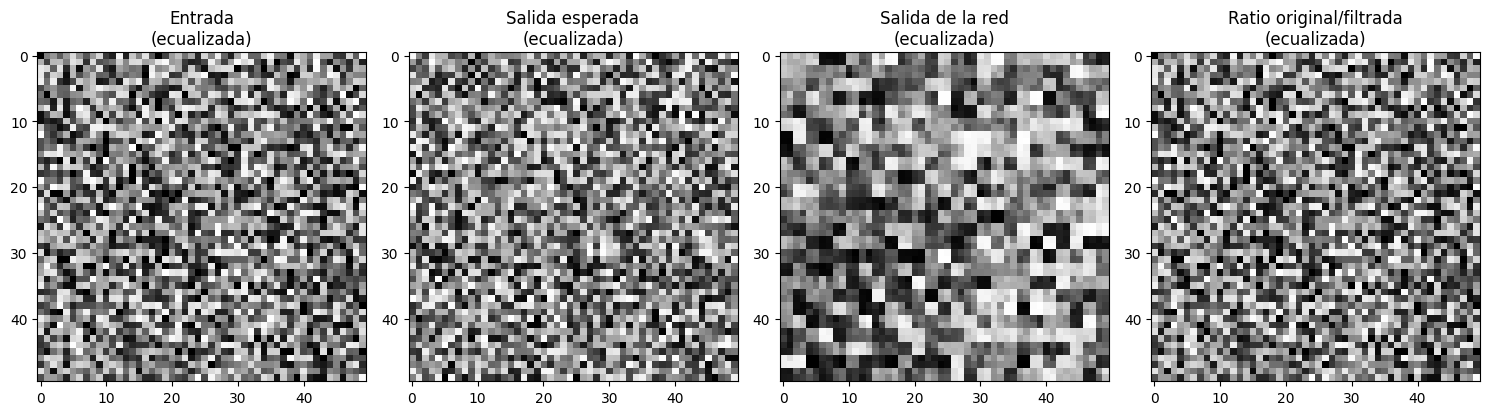

In [9]:
ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image_with_ratios(inputs, targets, outputs, ratios, ecualizar_hist, show_plot=True):

    index = int(n*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, target_red, salida_red, ratios = inputs[index, :, :], targets[index, :, :], outputs[index, :, :], ratios[index, :, :]

    imagenes = [entrada_red, target_red, salida_red, ratios]
    titulos = ['Entrada', 'Salida esperada', 'Salida de la red', 'Ratio original/filtrada']

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            imagen = ((imagen - imagen.min()) * 255) / (imagen.max() - imagen.min())
            imagen = cv2.equalizeHist(imagen.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()

graph_random_image_with_ratios(inputs, targets, outputs, ratios, ecualizar_hist)

## Filtro de primer orden

In [10]:
fom = first_order_method(config.training.pixeles_cuad, alphas, inputs, ratios)

El filtro perfecto produciría un estadístico de primer orden igual a 0.

Media del estadístico de 1er orden sobre todas las imágenes: 0.3079487979412079
Desviación estándar del estadístico de 1er orden sobre todas las imágenes: 0.1515735387802124



Text(0.5, 1.0, 'Distribución del estadístico de 1er orden')

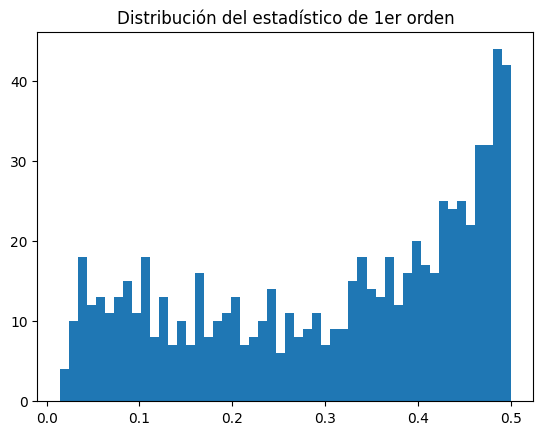

In [11]:
print(f'El filtro perfecto produciría un estadístico de primer orden igual a 0.\n')
print(f'Media del estadístico de 1er orden sobre todas las imágenes: {np.mean(fom)}')
print(f'Desviación estándar del estadístico de 1er orden sobre todas las imágenes: {np.std(fom)}\n')
plt.hist(fom, bins=50)
plt.title('Distribución del estadístico de 1er orden')

## Filtro de segundo orden

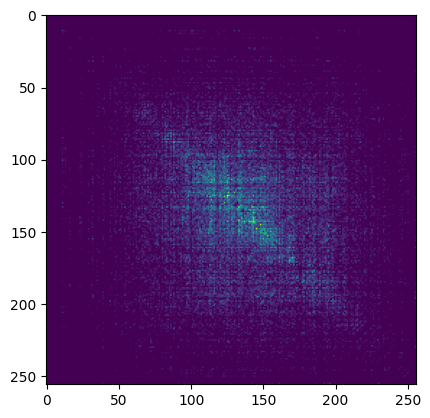

In [12]:
# Grafico una matriz de co-ocurrencias a modo de ejemplo
random_index = np.random.randint(0, outputs.shape[0] + 1)
glcm_avg = co_ocurrence_matrix(outputs[random_index])
plt.imshow(glcm_avg)

In [13]:
h(glcm_avg)

np.float64(0.03617875454163534)